# CEMS Crosswalk Testing

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pudl
import pandas as pd
import logging
import sys
import sqlalchemy as sa
import dask.dataframe as dd

In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
start_date=None
end_date=None
freq='AS'

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS')

## Get Transformed Crosswalk

In [7]:
from pudl.workspace.datastore import Datastore
from pudl.glue.epacamd_eia import extract, transform
ds = Datastore()
gens_ent = pd.read_sql('generators_entity_eia', pudl_engine)
boiler_ent = pd.read_sql('boilers_entity_eia', pudl_engine)

cems_crosswalk_dict = transform(extract(ds), gens_ent, boiler_ent, True)

Retrieving https://zenodo.org/api/deposit/depositions/7063255 from zenodo
Retrieving https://zenodo.org/api/files/afca4bd7-d94f-4af3-b1f3-abaeaec6fa68/datapackage.json from zenodo
Retrieving https://zenodo.org/api/files/afca4bd7-d94f-4af3-b1f3-abaeaec6fa68/epacamd_eia.zip from zenodo
Cleaning up the epacems-eia crosswalk


In [7]:
cems_crosswalk_dict.keys()

dict_keys(['epacamd_eia_crosswalk'])

In [8]:
cems_crosswalk = cems_crosswalk_dict["epacamd_eia_crosswalk"]

## Get CEMS from Parquet

In [13]:
epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/hourly_emissions_epacems.parquet')

cems_dd = dd.read_parquet(
    epacems_path, 
    columns=["year", "plant_id_eia", "unitid", "co2_mass_tons"],
)

# filters = pudl.output.epacems.year_state_filter(years=[2019], states=["ME"])

# cems_small_dd = dd.read_parquet(
#     epacems_path,
#     engine="pyarrow",
#     columns=["year", "state", "operating_datetime_utc", "operating_time_hours", "plant_id_eia", "facility_id", "unit_id_epa", "unitid"],
#     #filters=[[('year', '=', 2019)]],
#     index=False
# )

In [15]:
cems_df = cems_dd.groupby(["year", "plant_id_eia", "unitid"]).sum().compute()

In [ ]:
#idaho_cems = cems_small_dd[(cems_small_dd["state"]=="ID") & (cems_small_dd["year"]==2019)].compute()

In [ ]:
# This shows whether unitid and unit_id are 1:1 within a given year
test = cems_df_plant.dropna(subset="unit_id_epa").pipe(pudl.helpers.remove_leading_zeros_from_numeric_strings, "unitid")
ser = test.groupby(["operating_datetime_utc", "operating_time_hours", "plant_id_eia", "unit_id_epa"])["unitid"].nunique() 
print(ser[ser>1])

# This shows whether plant_id_eia and facility_id are 1:1 within a given year
test = cems_df_plant.dropna(subset="unit_id_epa").pipe(pudl.helpers.remove_leading_zeros_from_numeric_strings, "unitid")
ser = test.groupby(["operating_datetime_utc", "operating_time_hours", "facility_id"])["plant_id_eia"].nunique() 
print(ser[ser>1])

## Get Raw CEMS from Datastore

In [9]:
from pudl.workspace.datastore import Datastore
from pathlib import Path

# If you want to run the extractor with you LOCAL data, make sure you specify a path to your existing datastore with ds_kwargs
ds_kwargs = {"local_cache_path": Path(pudl_settings["pudl_in"]) / "data"}

# If you want to download the data from Zenodo, create the Datastore() instance without arguments.
ds = Datastore(**ds_kwargs)

In [19]:
cems_datastore = pudl.extract.epacems.EpaCemsDatastore(ds)
cems_partition = pudl.extract.epacems.EpaCemsPartition("2019", "ID")

raw_idaho_cems = cems_datastore.get_data_frame(cems_partition)

In [24]:
pudl.helpers.remove_leading_zeros_from_numeric_strings(raw_idaho_cems, "emissions_unit_id_epa")

,co2_mass_measurement_code,co2_mass_tons,emissions_unit_id_epa,gross_load_mw,heat_content_mmbtu,nox_mass_lbs,nox_mass_measurement_code,op_date,op_hour,operating_time_hours,plant_id_epa,so2_mass_lbs,so2_mass_measurement_code,state,steam_load_1000_lbs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2019,0,0.0,7456,NaN,NaN,ID,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2019,1,0.0,7456,NaN,NaN,ID,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2019,2,0.0,7456,NaN,NaN,ID,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2019,3,0.0,7456,NaN,NaN,ID,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2019,4,0.0,7456,NaN,NaN,ID,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,Measured,115.0,CT1,289.0,1935.6,13.549,Calculated,12-31-2019,19,1.0,57028,1.161,Measured,ID,NaN
70076,Measured,110.8,CT1,277.0,1864.8,11.189,Calculated,12-31-2019,20,1.0,57028,1.119,Measured,ID,NaN
70077,Measured,110.4,CT1,276.0,1857.9,11.147,Calculated,12-31-2019,21,1.0,57028,1.115,Measured,ID,NaN
70078,Measured,106.0,CT1,264.0,1783.1,10.699,Calculated,12-31-2019,22,1.0,57028,1.070,Measured,ID,NaN


In [22]:
raw_idaho_cems.loc[raw_idaho_cems["emissions_unit_id_epa"]=='1', "emissions_unit_id_epa"] = np.nan

In [26]:
raw_idaho_cems.emissions_unit_id_epa.str.contains("C")

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
70075    True
70076    True
70077    True
70078    True
70079    True
Name: emissions_unit_id_epa, Length: 70080, dtype: object

## Compare Crosswalk and CEMS

In [98]:
gens = pudl_out.gens_eia860()

#### **Data missing from the crosswalk**:

Plants that are in CEMS but not in the crosswalk

In [109]:
# Plants that are in CEMS but not in the crosswalk
cems_ids = cems_df.plant_id_eia.unique()
crosswalk_ids = cems_crosswalk.plant_id_epa.unique()
plant_id_not_in_crosswalk = [x for x in cems_ids if x not in crosswalk_ids]
plant_id_in_crosswalk = [x for x in cems_ids if x in crosswalk_ids]
print("Number of plants NOT IN crosswalk:", len(plant_id_not_in_crosswalk))
print("Number of plants IN crosswalk:", len(plant_id_in_crosswalk))

Number of plants NOT IN crosswalk: 281
Number of plants IN crosswalk: 1521


Plants that are in the crosswalk but units are missing

In [104]:
# Get a subset of the cems df that is only the plant ids that do show up in the 
# crosswalk. Theoretically this should show whether the unit ids are lining up.
plant_id_in_crosswalk = cems_crosswalk.dropna(subset="plant_id_eia").plant_id_epa.unique()
cems_df_only_crosswalk = cems_df[~cems_df["plant_id_eia"].isin(plant_id_not_in_crosswalk)]
cems_df_only_crosswalk = cems_df_only_crosswalk[cems_df_only_crosswalk["plant_id_eia"].isin(plant_id_in_crosswalk)]
cems_df_only_crosswalk = cems_df_only_crosswalk.rename(columns={"plant_id_eia": "plant_id_epa", "unitid": "unit_id_epa"})

# Clean cems subset
cems_df_only_crosswalk = pudl.helpers.remove_leading_zeros_from_numeric_strings(cems_df_only_crosswalk, "unit_id_epa")

# Merge the crosswalk with the cems df subset
merge_cems_with_crosswalk = pd.merge(
    cems_df_only_crosswalk, 
    cems_crosswalk[["plant_id_epa", "unit_id_epa", "plant_id_eia"]].drop_duplicates().dropna(), 
    on=["plant_id_epa", "unit_id_epa"],
    how="left"
)

# Print a list of the epa ids that have NA values for plant_id_eia matches. 
# This is an indication of units that don't match cems. Usually this is because
# the unit id does not exist in the crosswalk, but it could also be a misspelling or something.
merge_cems_with_crosswalk[merge_cems_with_crosswalk["plant_id_eia"].isna()].plant_id_epa.unique()

KeyError: "['unit_id_epa'] not in index"

#### **Note where EPA and EIA IDs don't match:**
This is usually a result of subcomponents being attributed to another plant

In [ ]:
miss_matched_ids = cems_crosswalk[cems_crosswalk["plant_id_eia"]!=cems_crosswalk["plant_id_epa"]].plant_id_epa.unique()
print("Number of missmatched EPA and EIA ids:", len(miss_matched_ids))
miss_matched_ids

In [ ]:
miss_matched_ids_df = cems_crosswalk[cems_crosswalk["plant_id_epa"].isin(miss_matched_ids)].copy()

In [ ]:
# This shows that while there are different plant id eia values in a given plant id epa,
# they are as granular as the unit_id_epa which is good for integration in CEMS!!! 
(miss_matched_ids_df.groupby(["plant_id_epa", "unit_id_epa"])["plant_id_eia"].nunique() >1).any()

In [ ]:
cems_crosswalk[cems_crosswalk["plant_id_epa"]==562]

In [ ]:
gens[(gens["plant_id_eia"]==562) & (gens["report_date"].dt.year==2020)]

In [ ]:
plant_id_not_in_crosswalk[0:10]

In [ ]:
[5, 247, 312, 334, 375, 569, 596, 604, 646, 647]

#### **What are the primary keys?**

In [234]:
# Shows that generator_id_epa does not distinguish between plant_id_eia values
(cems_crosswalk.groupby(["plant_id_epa", "unit_id_epa"])["plant_id_eia"].nunique() > 1).any()

False

#### **Explore**

To Do: 
- Check wheather `facility_id` and `unit_id_epa` mean anything
- rename columns in cems
- see if we can do any cems cleaning

In [ ]:
cems_df
test = cems_df.dropna(subset="unit_id_epa").pipe(pudl.helpers.remove_leading_zeros_from_numeric_strings, "unitid")
ser = test.groupby(["plant_id_eia", "unitid"])["unit_id_epa"].nunique() 
ser[ser>1]

## Test Boiler ID

In [56]:
# PUDL DB
#pudl_engine.table_names() # for a list of table names
boilers = pd.read_sql("boilers_entity_eia", pudl_engine)

In [29]:
boiler_id_not_in_entity_df = cems_crosswalk[~cems_crosswalk["boiler_id"].isin(boilers.boiler_id.unique())]
#boiler_id_not_in_entity_df = boiler_id_not_in_entity_df.dropna(subset=["boiler_id"])

In [104]:
boilers = pd.read_sql("boilers_entity_eia", pudl_engine)
cw = cems_crosswalk[["plant_id_eia", "boiler_id"]].drop_duplicates().dropna()
cw_tups = list(zip(cw.plant_id_eia, cw.boiler_id))
boiler_tups = list(zip(boilers.plant_id_eia, boilers.boiler_id))

In [102]:
# cw = cw.set_index(['plant_id_eia', 'boiler_id'])
# boilers = boilers.set_index(['plant_id_eia', 'boiler_id'])

In [97]:
cw.index.difference(boilers.index)

MultiIndex([], names=['plant_id_eia', 'boiler_id'])

In [82]:
[x for x in cw_tups if x not in boiler_tups]

[]

In [105]:
test1 = boilers[boilers["plant_id_eia"]==302].boiler_id

In [106]:
test2 = cems_crosswalk[cems_crosswalk["plant_id_eia"]==302].boiler_id

In [113]:
bad_ids = [302,1552,2378,2535,2850,6031,6136,10333]

In [115]:
boil_years = pd.read_sql("boiler_generator_assn_eia860", pudl_engine)
#pudl_engine.table_names()
boil_years[boil_years["plant_id_eia"].isin(bad_ids)].report_date.max()

Timestamp('2019-01-01 00:00:00')

In [85]:
[x for x in list(test2) if x not in list(test1)]

[]

In [118]:
gens[gens["plant_id_eia"]==302].report_date.max()

Timestamp('2021-01-01 00:00:00')

In [86]:
print(list(test1))
print(list(test2))

['5', '4', '3', '2', '1']
['1', '2', '3', '4', '5']


In [73]:
test2

161    1
163    2
164    3
165    4
166    5
Name: boiler_id, dtype: string

## Test Timezone

In [152]:
# PUDL DB
#pudl_engine.table_names() # for a list of table names
plants_entity = pd.read_sql("plants_entity_eia", pudl_engine)

In [197]:
pudl_engine.has_table("assn_gen_eia_unit_epa")

/var/folders/cd/6w7fpp711lsglpq_fxb57l3m0000gn/T/ipykernel_44638/1566893324.py:1: SADeprecationWarning: The Engine.has_table() method is deprecated and will be removed in a future release.  Please refer to Inspector.has_table(). (deprecated since: 1.4)
  pudl_engine.has_table("assn_gen_eia_unit_epa")


True

In [161]:
timezones = plants_entity[["plant_id_eia", "timezone"]].dropna().copy()

In [160]:
# import datetime
# import pytz

# jan1 = datetime.datetime(2011, 1, 1)  # year doesn't matter
# timezones["utc_offset"] = timezones["timezone"].apply(
#     lambda tz: pytz.timezone(tz).localize(jan1).utcoffset()
# )
# del timezones["timezone"]

In [167]:
timezones

,plant_id_eia,timezone
0,1,America/Anchorage
1,2,America/Chicago
2,3,America/Chicago
3,4,America/Chicago
4,5,America/Chicago
...,...,...
14929,880100,America/New_York
14930,880101,America/Chicago
14931,880107,America/New_York
14932,880108,America/Indiana/Vincennes


In [177]:
miss_matched_ids_df1 = miss_matched_ids_df.merge(timezones, on=["plant_id_eia"], how="left")

In [183]:
miss_matched_ids_df2 = miss_matched_ids_df1.merge(timezones, left_on=["plant_id_epa"], right_on=["plant_id_eia"], how="left", suffixes=["_eia", "_epa"])

In [185]:
miss_matched_ids_df2 = miss_matched_ids_df2.drop(columns=["plant_id_eia_epa"]).rename(columns={"plant_id_eia_eia": "plant_id_eia"})

In [188]:
miss_matched_ids_df2[miss_matched_ids_df2["timezone_eia"]!=miss_matched_ids_df2["timezone_epa"]]

,plant_id_epa,unit_id_epa,generator_id_epa,plant_id_eia,boiler_id,generator_id,timezone_eia,timezone_epa


In [213]:
from sqlalchemy import inspect
insp = inspect(pudl_engine)

In [219]:
%%time
if not insp.has_table("assn_gen_eia_unit_epa"):
    print("bad")

CPU times: user 1.72 ms, sys: 1.09 ms, total: 2.81 ms
Wall time: 3.96 ms


In [218]:
%%time
if "assn_gen_eia_unit_epa" not in insp.get_table_names():
    print("bad")

CPU times: user 217 µs, sys: 160 µs, total: 377 µs
Wall time: 243 µs


In [208]:
pudl_engine.table_names()[:5]

/var/folders/cd/6w7fpp711lsglpq_fxb57l3m0000gn/T/ipykernel_44638/454621952.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  pudl_engine.table_names()[:5]


['assn_gen_eia_unit_epa',
 'assn_plant_id_eia_epa',
 'boiler_fuel_eia923',
 'boiler_generator_assn_eia860',
 'boilers_entity_eia']

In [212]:
if "plants_eia860" not in inspector.get_table_names():

AssertionError: bad

In [224]:
miss_matched_ids_df1.shape

(161, 7)

## Test EPACEMS Output Table

In [63]:
epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/hourly_emissions_epacems.parquet')

test = pudl.output.epacems.epacems(
    states = ["ID"],
    years = [2019],
    #columns: Sequence[str] | None = None,
    epacems_path = epacems_path,
)

## Next

In [27]:
test = cems_crosswalk.dropna(subset="boiler_id")
dups = test[test.duplicated(subset=["plant_id_eia", "generator_id"], keep=False)]
tups = tuple(zip(dups.plant_id_eia, dups.boiler_id))
boil_dups = test[test.duplicated(subset=["plant_id_eia", "boiler_id"], keep=False)]
boil_dup_tups = tuple(zip(boil_dups.plant_id_eia, boil_dups.boiler_id))
[x for x in tups if x in boil_dup_tups]

test[test["plant_id_eia"]==612]

,plant_id_epa,emissions_unit_id_epa,generator_id_epa,plant_id_eia,boiler_id,generator_id
396,612,FMCT2A,ST1,612,2A,ST1
397,612,FMCT2A,ST2,612,2A,ST2
399,612,FMCT2B,ST1,612,2B,ST1
400,612,FMCT2B,ST2,612,2B,ST2
402,612,FMCT2C,ST1,612,2C,ST1
403,612,FMCT2C,ST2,612,2C,ST2
405,612,FMCT2D,ST1,612,2D,ST1
406,612,FMCT2D,ST2,612,2D,ST2
408,612,FMCT2E,ST1,612,2E,ST1
409,612,FMCT2E,ST2,612,2E,ST2


In [73]:
gens = pudl_out.gens_eia860()

Filling technology type
Filled technology_type coverage now at 98.1%


In [31]:
gens[(gens["plant_id_eia"]==612) & (gens["report_date"].dt.year==2020)]

,report_date,plant_id_eia,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,generator_id,associated_combined_heat_power,balancing_authority_code_eia,balancing_authority_name_eia,bga_source,bypass_heat_recovery,capacity_mw,carbon_capture,city,cofire_fuels,county,current_planned_operating_date,data_source,deliver_power_transgrid,distributed_generation,duct_burners,energy_source_1_transport_1,energy_source_1_transport_2,energy_source_1_transport_3,energy_source_2_transport_1,energy_source_2_transport_2,energy_source_2_transport_3,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,fluidized_bed_tech,fuel_type_code_pudl,fuel_type_count,grid_voltage_2_kv,grid_voltage_3_kv,grid_voltage_kv,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,operating_date,operating_switch,operational_status,operational_status_code,original_planned_operating_date,other_combustion_tech,other_modifications_date,other_planned_modifications,owned_by_non_utility,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,previously_canceled,primary_purpose_id_naics,prime_mover_code,pulverized_coal_tech,reactive_power_output_mvar,retirement_date,rto_iso_lmp_node_id,rto_iso_location_wholesale_reporting_id,sector_id_eia,sector_name_eia,solid_fuel_gasification,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,stoker_tech,street_address,subcritical_tech,summer_capacity_estimate,summer_capacity_mw,summer_estimated_capability_mw,supercritical_tech,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,timezone,topping_bottoming_code,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,unit_id_pudl,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
60165,2020-01-01,612,205,Fort Myers,6452,121,Florida Power & Light Co,11,False,FPL,Florida Power & Light Company,<NA>,False,62.0,<NA>,Ft. Myers,<NA>,Lee,NaT,eia860,<NA>,<NA>,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,DFO,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,oil,2,NaN,NaN,230.0,<NA>,26.6967,-81.7831,5.0,<NA>,0.90,1974-05-01,<NA>,retired,RE,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,GT,<NA>,NaN,2016-12-01,<NA>,<NA>,1,Electric Utility,False,<NA>,<NA>,<NA>,<NA>,FL,<NA>,10650 State Rd 80,<NA>,<NA>,54.0,NaN,<NA>,False,False,Petroleum Liquids,10M,America/New_York,X,<NA>,<NA>,<NA>,<NA>,NaT,False,<NA>,60.0,NaN,33902
60164,2020-01-01,612,205,Fort Myers,6452,121,Florida Power & Light Co,12,False,FPL,Florida Power & Light Company,<NA>,False,62.0,<NA>,Ft. Myers,<NA>,Lee,NaT,eia860,<NA>,<NA>,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,DFO,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,oil,2,NaN,NaN,230.0,<NA>,26.6967,-81.7831,5.0,<NA>,0.90,1974-05-01,<NA>,retired,RE,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,GT,<NA>,NaN,2016-12-01,<NA>,<NA>,1,Electric Utility,False,<NA>,<NA>,<NA>,<NA>,FL,<NA>,10650 State Rd 80,<NA>,<NA>,54.0,NaN,<NA>,False,False,Petroleum Liquids,10M,America/New_York,X,<NA>,<NA>,<NA>,<NA>,NaT,False,<NA>,60.0,NaN,33902
60163,2020-01-01,612,205,Fort Myers,6452,121,Florida Power & Light Co,2A,False,FPL,Florida Power & Light Company,unit_connection,True,188.2,<NA>,Ft. Myers,<NA>,Lee,NaT,eia860,<NA>,<NA>,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NG,DFO,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,gas,2,NaN,NaN,230.0,<NA>,26.6967,-81.7831,90.0,True,0.85,2000-12-01

In [32]:
len(gens)

491469

In [85]:
gen_pairs = gens[["plant_id_eia", "generator_id", "fuel_type_code_pudl", "capacity_mw"]].drop_duplicates(subset=["plant_id_eia", "generator_id"])

len(gen_pairs)

35646

In [86]:
gen_cross = pd.merge(gen_pairs, cems_crosswalk, on=["plant_id_eia", "generator_id"], how="left")

In [87]:
no_dup_gen_cross = gen_cross.drop_duplicates(subset=["plant_id_eia", "generator_id"])

In [88]:
len(no_dup_gen_cross)

35646

In [89]:
len(no_dup_gen_cross[
    no_dup_gen_cross["plant_id_epa"].isna() 
    #& (~no_dup_gen_cross["fuel_type_code_pudl"].isin(["solar", "wind", "hydro"]))
])

30349

In [102]:
len(not_mapped := no_dup_gen_cross[
    no_dup_gen_cross["plant_id_epa"].isna() 
    & (~no_dup_gen_cross["fuel_type_code_pudl"].isin(["solar", "wind", "hydro"]))
])

len(mapped := no_dup_gen_cross[
    no_dup_gen_cross["plant_id_epa"].notna() 
    & (~no_dup_gen_cross["fuel_type_code_pudl"].isin(["solar", "wind", "hydro"]))
])


5294

In [103]:
not_mapped.fuel_type_code_pudl.describe()

count     17203
unique        6
top         gas
freq       6828
Name: fuel_type_code_pudl, dtype: object

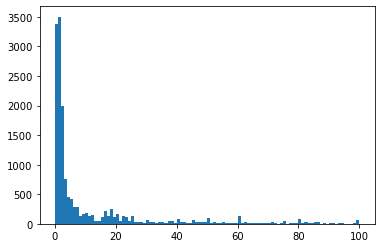

In [104]:
import matplotlib.pyplot as plt
plt.hist(not_mapped.capacity_mw, bins=100, range=(0,100))
plt.show()

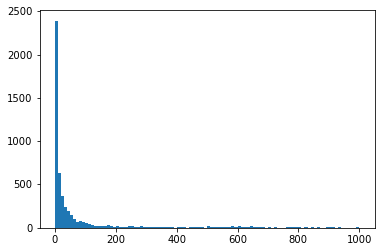

In [113]:
import matplotlib.pyplot as plt
plt.hist(not_mapped.groupby("plant_id_eia").capacity_mw.sum(), bins=100, range=(0,1000))
plt.show()

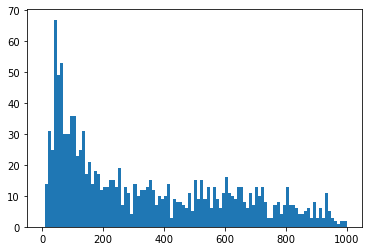

In [112]:
plt.hist(mapped.groupby("plant_id_eia").capacity_mw.sum(), bins=100, range=(0,1000))
plt.show()

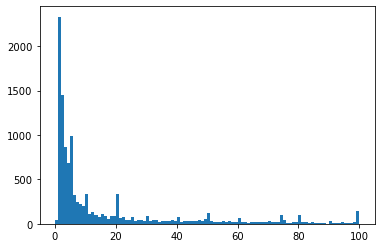

In [109]:
plt.hist(no_dup_gen_cross.groupby("plant_id_eia").capacity_mw.sum(), bins=100, range=(0,100))
plt.show()

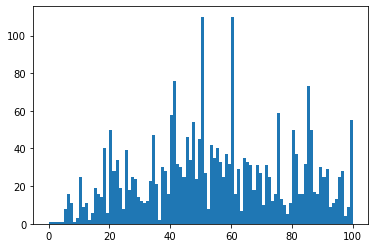

In [108]:
plt.hist(mapped.capacity_mw, bins=100, range=(0,100))
plt.show()

In [114]:
cems_crosswalk

,plant_id_epa,emissions_unit_id_epa,generator_id_epa,plant_id_eia,boiler_id,generator_id
0,3,1,1,3,1,1
1,3,2,2,3,2,2
2,3,3,3,3,3,3
3,3,4,4,3,4,4
4,3,5,5,3,5,5
...,...,...,...,...,...,...
6820,60903,1,3,60903,<NA>,3
6821,60903,2,2,60903,0002,2
6822,60903,2,4,60903,<NA>,4
6823,70454,MAG1,MAG1,54538,<NA>,MAG1


## Investigate One-to-Many relationship

In [ ]:
crosswalk_essentials = cems_crosswalk[["plant_id_eia", "emissions_unit_id_epa", "generator_id"]].drop_duplicates()

In [ ]:
# Add columns showing relationship between emissions unit and generator id columns
crosswalk_essentials["em_gen_1_m"] = crosswalk_essentials.groupby(["plant_id_eia", "emissions_unit_id_epa"])["generator_id"].transform(lambda x: x.count() > 1)
crosswalk_essentials["em_gen_m_1"] = crosswalk_essentials.groupby(["plant_id_eia", "generator_id"])["emissions_unit_id_epa"].transform(lambda x: x.count() > 1)

crosswalk_essentials[crosswalk_essentials["em_gen_1_m"] & crosswalk_essentials["em_gen_m_1"]]

In [68]:
# For all the em_gen_1_m = TRUE we will need to allocate by net generation or capacity
# This is an example: 
cems_crosswalk[cems_crosswalk["plant_id_eia"]==3]

,plant_id_epa,emissions_unit_id_epa,generator_id_epa,plant_id_eia,boiler_id,generator_id
0,3,1,1,3,1,1
1,3,2,2,3,2,2
2,3,3,3,3,3,3
3,3,4,4,3,4,4
4,3,5,5,3,5,5
5,3,6A,A1CT,3,<NA>,A1CT
6,3,6A,A1ST,3,6A,A1ST
7,3,6B,A1CT2,3,<NA>,A1CT2
8,3,6B,A1ST,3,6B,A1ST
9,3,7A,A2C1,3,<NA>,A2C1


## Missing Records

In [81]:
crosswalk_ids = (
    cems_crosswalk[["plant_id_eia", "generator_id"]]
    .drop_duplicates()
    .set_index(["plant_id_eia", "generator_id"])
)
gens_ids = (
    gens[["plant_id_eia", "generator_id"]]
    .drop_duplicates()
    .set_index(["plant_id_eia", "generator_id"])
)

In [96]:
gens_ids.index.difference(crosswalk_ids.index)

MultiIndex([(    1,     '1'),
            (    1,     '2'),
            (    1,     '3'),
            (    1,     '5'),
            (    1,   'WT1'),
            (    1,   'WT2'),
            (    2,     '1'),
            (    3,  'A3C1'),
            (    3,  'A3ST'),
            (    4,     '1'),
            ...
            (65328,     '1'),
            (65329, 'LAURL'),
            (65330, 'BALB1'),
            (65331, 'NORMA'),
            (65332,   'MH1'),
            (65333,   '785'),
            (65334, 'PLTVW'),
            (65335, 'WAPPA'),
            (65337, 'MAYBK'),
            (65338, 'UNIS1')],
           names=['plant_id_eia', 'generator_id'], length=30349)

In [97]:
gens

,report_date,plant_id_eia,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,generator_id,associated_combined_heat_power,balancing_authority_code_eia,balancing_authority_name_eia,bga_source,bypass_heat_recovery,capacity_mw,carbon_capture,city,cofire_fuels,county,current_planned_operating_date,data_source,deliver_power_transgrid,distributed_generation,duct_burners,energy_source_1_transport_1,energy_source_1_transport_2,energy_source_1_transport_3,energy_source_2_transport_1,energy_source_2_transport_2,energy_source_2_transport_3,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,fluidized_bed_tech,fuel_type_code_pudl,fuel_type_count,grid_voltage_2_kv,grid_voltage_3_kv,grid_voltage_kv,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,operating_date,operating_switch,operational_status,operational_status_code,original_planned_operating_date,other_combustion_tech,other_modifications_date,other_planned_modifications,owned_by_non_utility,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,previously_canceled,primary_purpose_id_naics,prime_mover_code,pulverized_coal_tech,reactive_power_output_mvar,retirement_date,rto_iso_lmp_node_id,rto_iso_location_wholesale_reporting_id,sector_id_eia,sector_name_eia,solid_fuel_gasification,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,stoker_tech,street_address,subcritical_tech,summer_capacity_estimate,summer_capacity_mw,summer_estimated_capability_mw,supercritical_tech,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,timezone,topping_bottoming_code,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,unit_id_pudl,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
491468,2001-01-01,2,848,Bankhead Dam,195,18,Alabama Power Co,1,False,SOCO,"Southern Company Services, Inc. - Trans",<NA>,False,45.0,<NA>,Northport,<NA>,Tuscaloosa,NaT,<NA>,<NA>,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,WAT,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,hydro,1,NaN,NaN,115.0,<NA>,33.458665,-87.35682,NaN,<NA>,NaN,1963-07-01,<NA>,existing,OP,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,HY,<NA>,NaN,NaT,<NA>,<NA>,1,Electric Utility,<NA>,<NA>,<NA>,<NA>,<NA>,AL,<NA>,19001 Lock 17 Road,<NA>,<NA>,56.0,NaN,<NA>,<NA>,<NA>,Conventional Hydroelectric,<NA>,America/Chicago,X,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,56.0,NaN,35476
491467,2001-01-01,3,32,Barry,195,18,Alabama Power Co,1,False,SOCO,"Southern Company Services, Inc. - Trans",<NA>,False,153.1,<NA>,Bucks,<NA>,Mobile,NaT,<NA>,<NA>,False,False,WT,<NA>,<NA>,PL,<NA>,<NA>,BIT,NG,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,coal,3,NaN,NaN,230.0,<NA>,31.006900,-88.01030,NaN,<NA>,NaN,1954-02-01,<NA>,existing,OP,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,ST,True,NaN,NaT,<NA>,<NA>,1,Electric Utility,<NA>,<NA>,<NA>,<NA>,<NA>,AL,<NA>,North Highway 43,True,<NA>,138.0,NaN,<NA>,<NA>,<NA>,Conventional Steam Coal,<NA>,America/Chicago,X,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,138.0,NaN,36512
491466,2001-01-01,3,32,Barry,195,18,Alabama Power Co,2,False,SOCO,"Southern Company Services, Inc. - Trans",<NA>,False,153.1,<NA>,Bucks,<NA>,Mobile,NaT,<NA>,<NA>,False,False,WT,<NA>,<NA>,PL,<NA>,<NA>,BIT,NG,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,coal,3,NaN,NaN,230.0,<NA>,31.006900,-88.01030,NaN,<NA>,NaN,1954-07-01,<NA>,existing,OP,